# Reading 4 ECG Signals

In [2]:
import wfdb
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import statsmodels.api as sm
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pywt
from joblib import dump, load
from sklearn.linear_model import LogisticRegression

In [8]:
data_path = r'C:\Users\m3394\OneDrive\Desktop\ECG-based-authentication-interface-main\ECG-based-authentication-interface-main\ECG-based-authentication-interface-main\dataset2'
ecg_signals =[]
ecg_fields = []

for tr_smple in os.listdir(data_path):
    print(tr_smple)
    for record_name in os.listdir(os.path.join(data_path,tr_smple)):
        
        #extract just the number of record without extension
        record_path=os.path.join(data_path,tr_smple,record_name.split('.')[0])
                                  
        #use just one channel nested of 15                          
        signal, fields = wfdb.rdsamp(record_path, channels=[1])
                                  
        ecg_signals.append(signal)
        ecg_fields.append(fields)
        break
THE_SIGNAL_LENGTH=len(ecg_signals[3])
print(THE_SIGNAL_LENGTH)


patient001
patient005
patient006
patient008
115200


### Plotting each signal

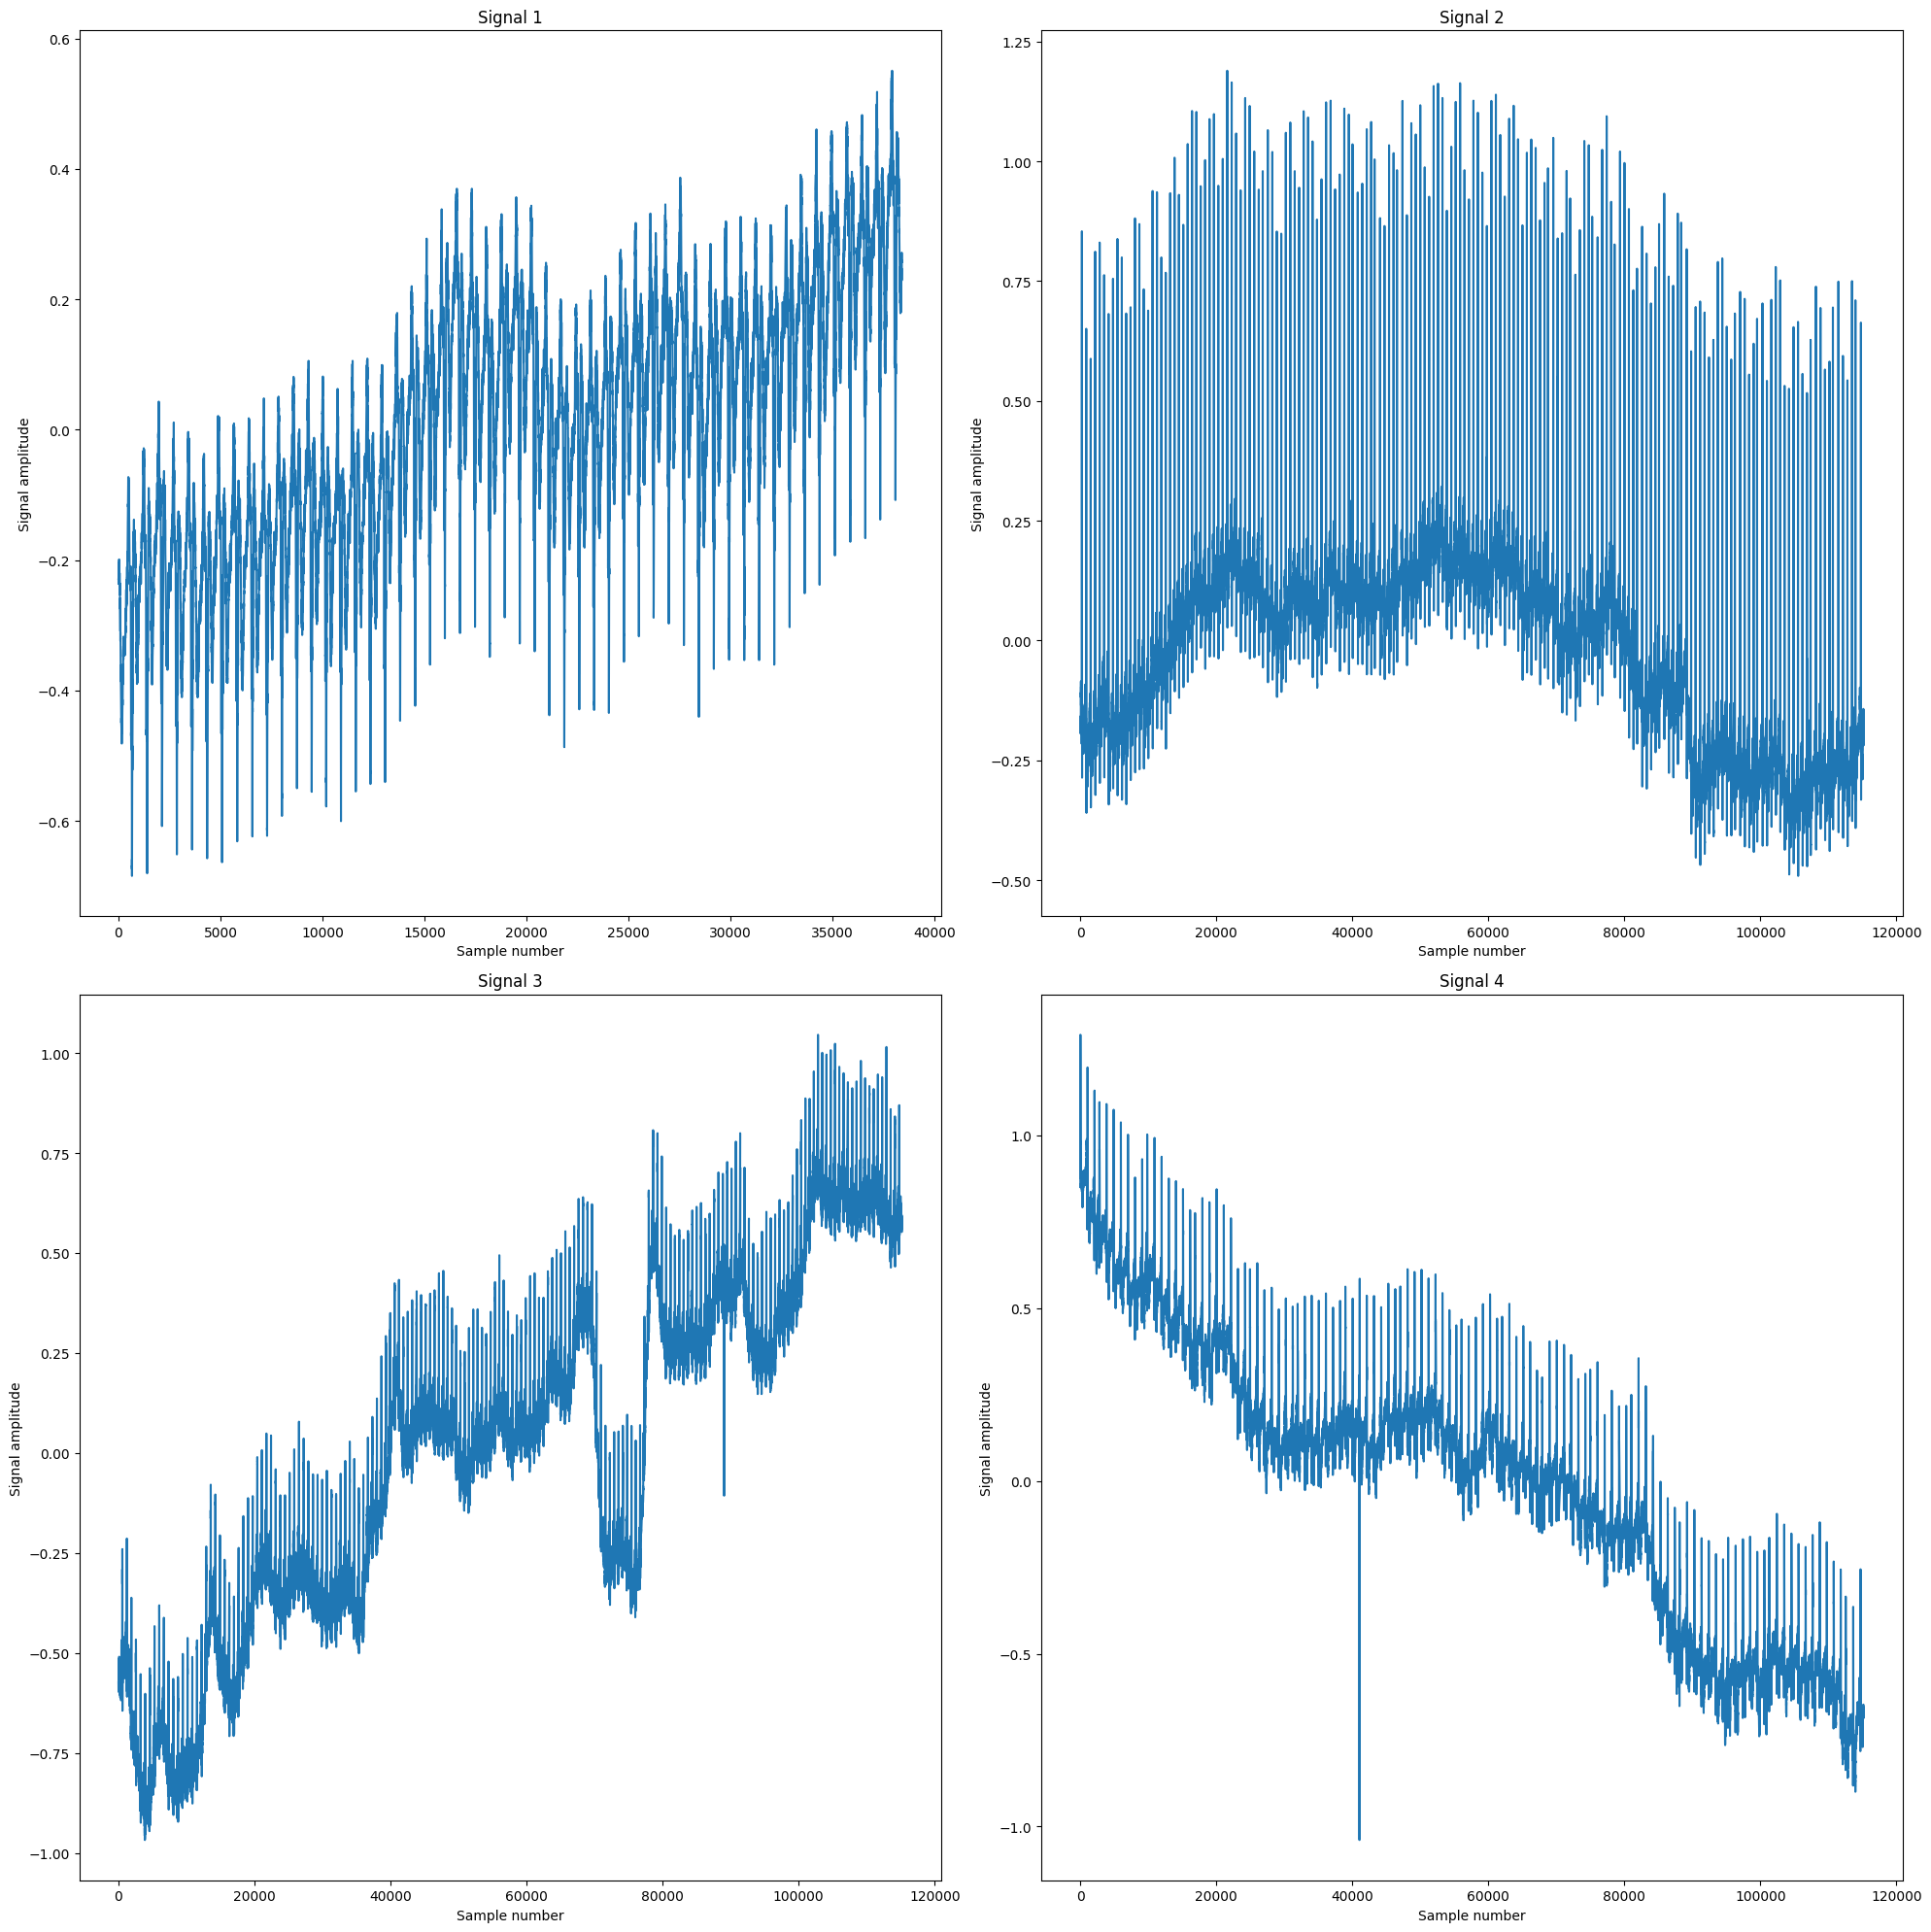

In [9]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# Plot each ECG signal on a separate subplot
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].plot(ecg_signals[i])
    axs[row, col].set_xlabel('Sample number')
    axs[row, col].set_ylabel('Signal amplitude')
    axs[row, col].set_title(f'Signal {i+1}')

# Adjust subplot spacing and display the plot
plt.tight_layout()
plt.show()


# Preprocessing

### bandpass filter

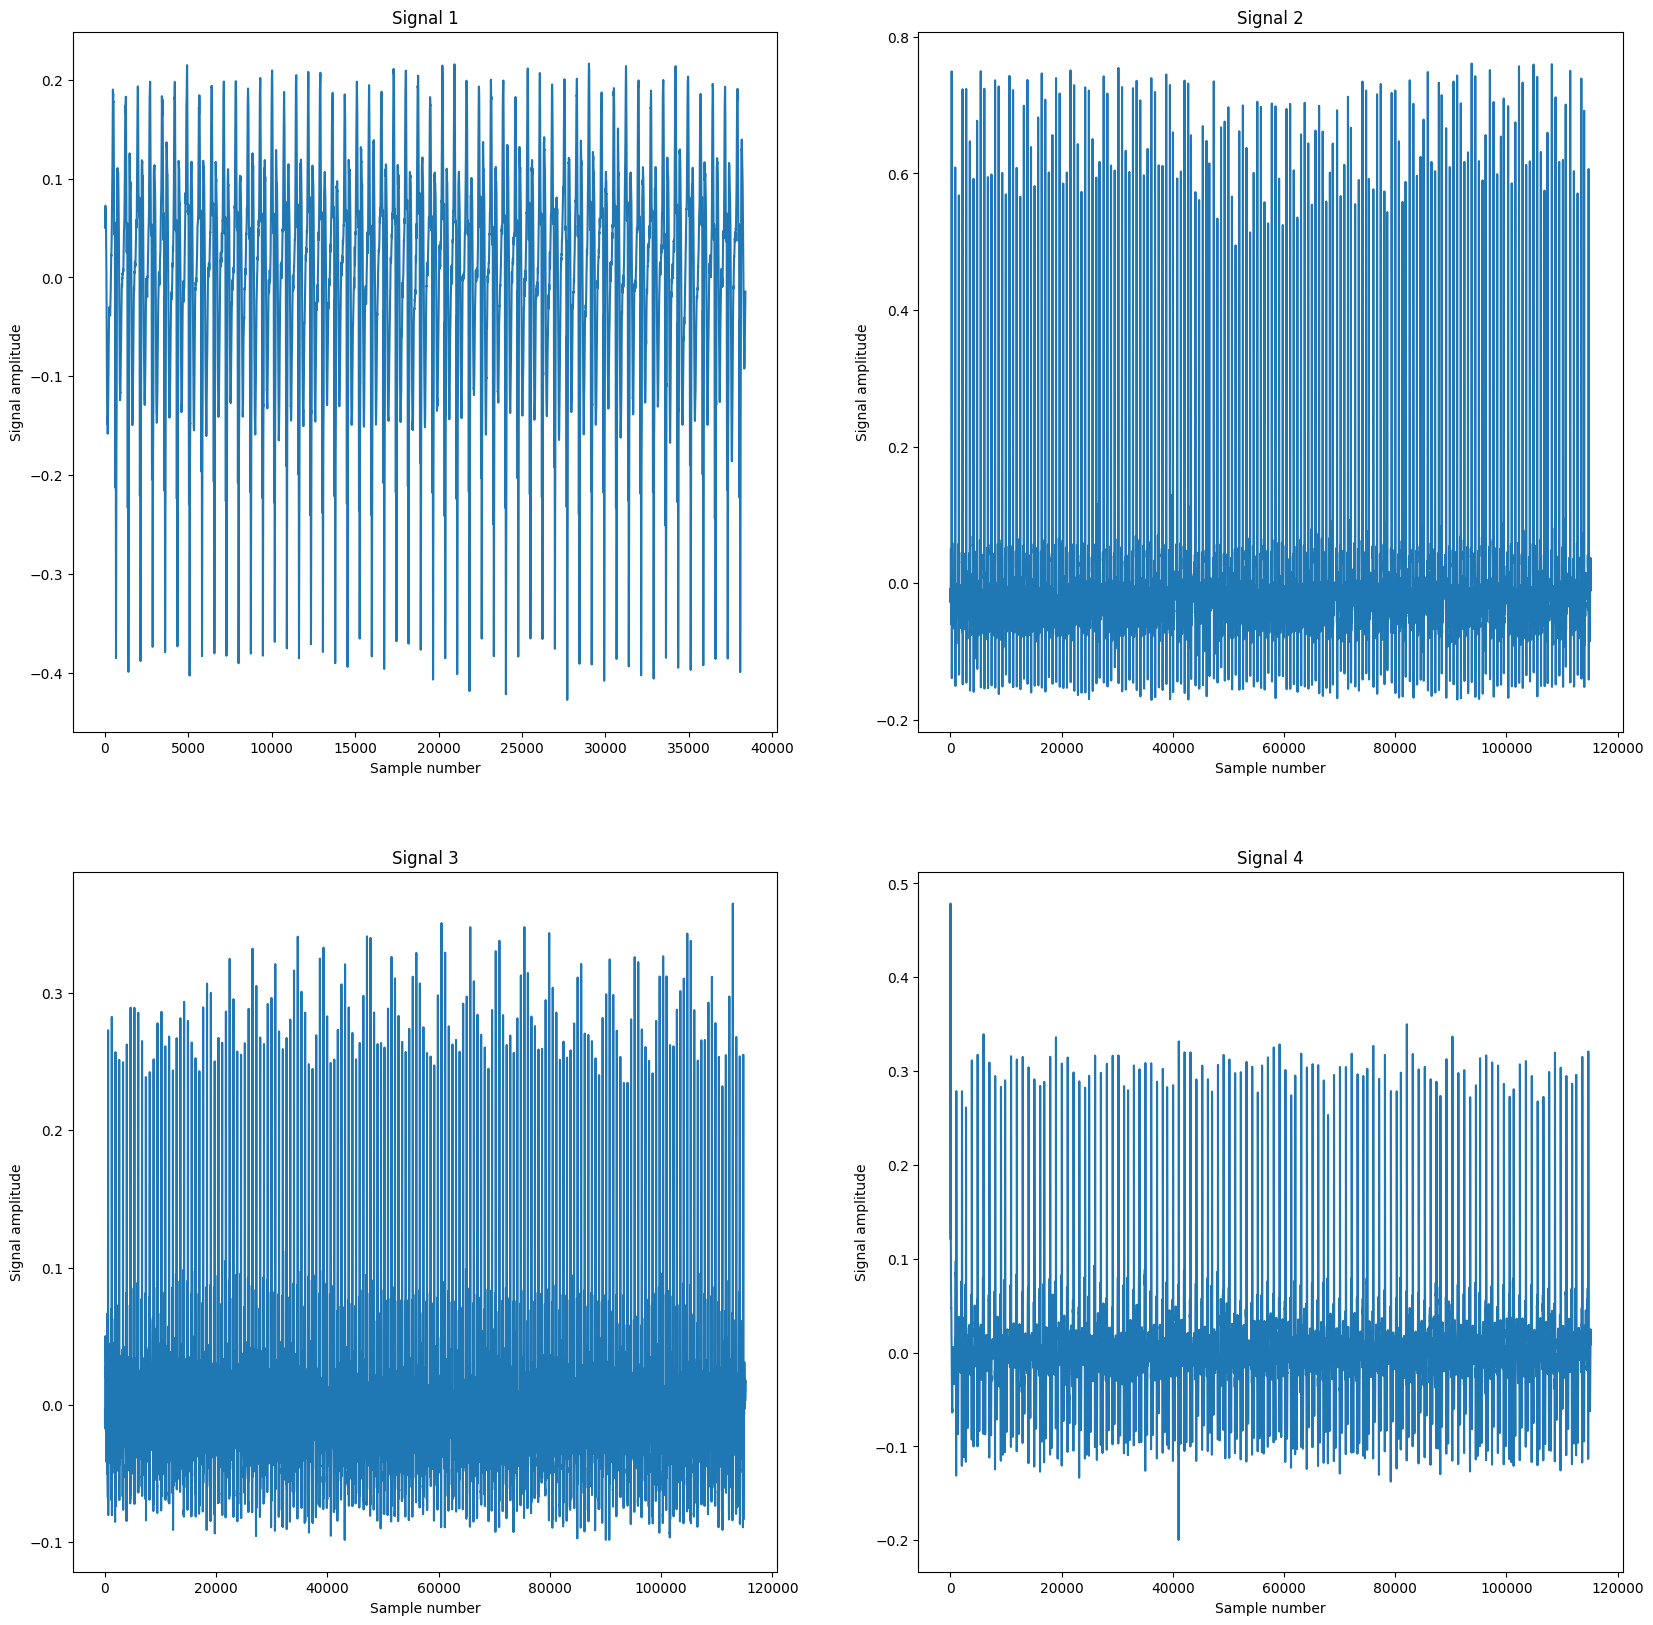

In [10]:
filtered_signals = []

# Define bandpass filter parameters
low_cut = 1.0
high_cut = 40.0
order = 2

# Apply bandpass filter to the signal
for i in range(4):
    fs = ecg_fields[i]['fs']
    nyq = 0.5 * fs
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signals[i][:, 0])
    filtered_signals.append(filtered)


fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].plot(filtered_signals[i])
    axs[row, col].set_xlabel('Sample number')
    axs[row, col].set_ylabel('Signal amplitude')
    axs[row, col].set_title(f'Signal {i+1}')

plt.show()

### Segmentation

In [39]:
# Define the segment length and overlap (in samples)
segment_len = 2000
overlap = 1000

# Create an empty list to store the segments
segment_list = []
segment_class = []

# Loop over each ECG signal in the 'ecg_signals' list
for i in range(len(filtered_signals)):
    
    # Calculate the total number of segments in the signal
    num_segments = int(np.ceil((len(filtered_signals[i]) - segment_len) / overlap)) + 1
    
    # Loop over each segment in the signal
    for j in range(num_segments):
        
        # Calculate the start and end indices of the current segment
        start = j * overlap
        end = start + segment_len
        
        # Make sure the segment doesn't exceed the length of the signal
        if end > len(filtered_signals[i]):
            end = len(filtered_signals[i])
            start = end - segment_len
        
        # Extract the current segment from the signal
        segment = filtered_signals[i][start:end]
        
        # Append the segment to the segment list
        segment_list.append(segment)
        segment_class.append(i)

In [15]:
features1 = np.array(segment_list)
features1.shape

(383, 2000)

# Fiducial Features

In [16]:
R_indices = []
for i in range (4):
    peaks, _ = find_peaks(filtered_signals[i], distance=550)
    R_indices.append(peaks)

In [17]:
S_indices = []
fs = 1000
for i in range(4):
    s_idx = []
    for r_peak in R_indices[i]:
        # Find the minimum value in a small window after the R-peak
        window_size = int(0.04 * fs)
        local_min_index = np.argmin(filtered_signals[i][r_peak:r_peak+window_size])
        s_idx.append(r_peak + local_min_index)
    S_indices.append(s_idx)

In [18]:
Q_indices = []
fs = 1000
for i in range(4):
    q_idx = []
    for r_peak in R_indices[i]:
        window_size = int(0.1 * fs)
        start = r_peak - window_size
        if start < 0:
            start = 0
        local_min_index = np.argmin(filtered_signals[i][start:r_peak -1])
        q_idx.append(start + local_min_index)
    Q_indices.append(q_idx)

In [19]:
T_indices = []
fs = 1000
for i in range(4):
    t_idx = []
    for r_peak in R_indices[i]:
        window_size = int(0.4 * fs)
        local_max_index = np.argmax(filtered_signals[i][r_peak + 40:r_peak+ 40 + window_size])
        t_idx.append(r_peak + 40 + local_max_index)
    T_indices.append(t_idx)

In [20]:
P_indices = []
fs = 1000
for i in range(4):
    p_idx = []
    for r_peak in R_indices[i]:
        window_size = int(0.2 * fs)
        start = r_peak - window_size - 40
        if start < 0:
            start = 0
        local_max_index = np.argmax(filtered_signals[i][start:r_peak -40])
        p_idx.append(start + local_max_index)
    P_indices.append(p_idx)

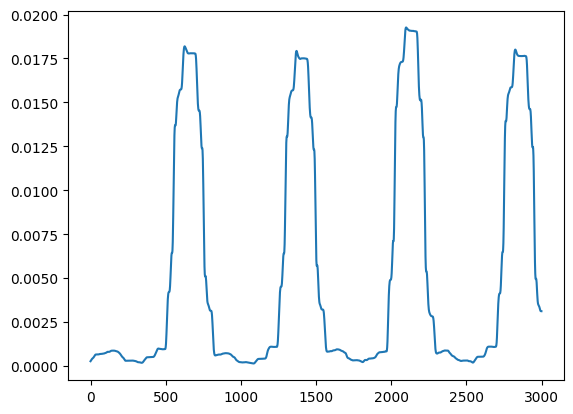

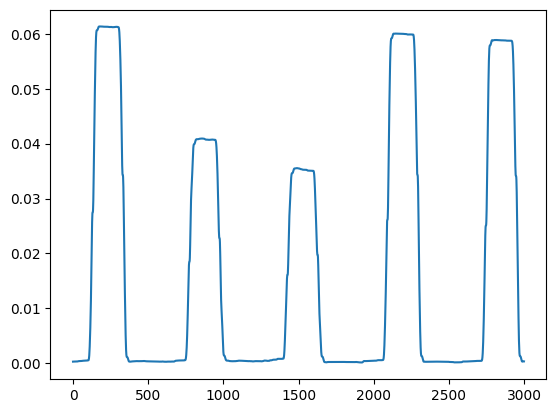

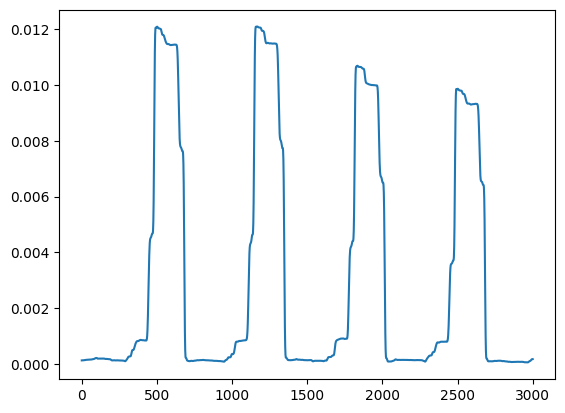

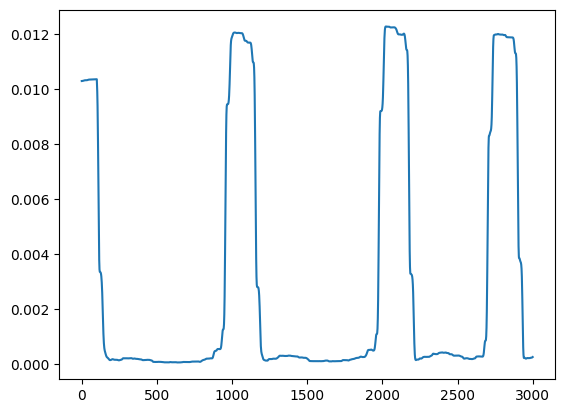

In [21]:
def pan_and_tompkins(signals):
    convolved_Signals = []
    for i in signals:
        dx = np.diff(i)
        dx = np.square(dx)
        dx = np.convolve(dx, np.ones(200), mode='same')
        convolved_Signals.append(dx)
        plt.plot(dx[0:3000])
        plt.show()
    return convolved_Signals

def find_qrs_onset_and_offset(r_peaks, convolved_signals):
    qrs_onsets = []
    qrs_offsets = []

    for r_peak in r_peaks:
        # Find QRS onset
        qrs_onset = r_peak
        while qrs_onset > 0 and convolved_signals[qrs_onset] > 0.1 * convolved_signals[r_peak]:
            qrs_onset -= 1

        # Find QRS offset
        qrs_offset = r_peak
        while qrs_offset < len(convolved_signals)-1 and convolved_signals[qrs_offset] > 0.1 *convolved_signals[r_peak]:
            qrs_offset += 1

        qrs_onsets.append(qrs_onset)
        qrs_offsets.append(qrs_offset)
    return qrs_onsets, qrs_offsets

convolved_signals = pan_and_tompkins(filtered_signals)
QRS_onset = []
QRS_offset = []
for i in range(4):
    on, off = find_qrs_onset_and_offset(R_indices[i], convolved_signals[i])
    QRS_onset.append(on)
    QRS_offset.append(off)

In [22]:
def calculate_waves_onset_and_offset(signals, wave_indices, search_space):
    onsets = []
    offsets = []
    for i in range(len(signals)):
        onset = []
        offset = []
        for peak in wave_indices[i]:
            xx = (peak, filtered_signals[i][peak]) # peak
            y_left = (peak - search_space, filtered_signals[i][peak - search_space])
            s = min(peak+search_space, len(filtered_signals[i]) -1 )
            y_right = (s, filtered_signals[i][s])
            a_vector_left = (y_left[0] - xx[0], y_left[1] - xx[1])
            a_vector_right = (y_right[0] - xx[0], y_right[1] - xx[1])

            maximum_left = maximum_right =  max_idx_left = max_idx_right = -1
            for point in range(search_space):
                care2 = min(peak+point, len(filtered_signals[i]) - 1)
                m_left = (peak-point, filtered_signals[i][peak-point])
                m_right = (care2, filtered_signals[i][care2])
                c_vector_left = (m_left[0] - xx[0], m_left[1] - xx[1])
                c_vector_right = (m_right[0] - xx[0], m_right[1] - xx[1])
                cross_left = np.cross(a_vector_left, c_vector_left)
                cross_right = np.cross(a_vector_right, c_vector_right)
                sigma_left = np.abs(cross_left) / np.abs(np.linalg.norm(a_vector_left))
                sigma_right = np.abs(cross_right) / np.abs(np.linalg.norm(a_vector_right))

                if sigma_left > maximum_left:
                    maximum_left = sigma_left
                    max_idx_left = peak - point

                if sigma_right > maximum_right:
                    maximum_right = sigma_right
                    max_idx_right = care2

            onset.append(max_idx_left)
            offset.append(max_idx_right)

        onsets.append(onset)
        offsets.append(offset)

    return onsets, offsets

In [23]:
P_onset, P_offset = calculate_waves_onset_and_offset(filtered_signals, P_indices, 80)
T_onset, T_offset = calculate_waves_onset_and_offset(filtered_signals, T_indices, 180)
#QRS_onset, QRS_offset = calculate_waves_onset_and_offset(convolved_signals, R_indices, 200)

In [24]:
features3 = []
beats_classes = []
fs = 1000.0

for i in range(4):
    for j in range(len(P_indices[i])):
        QT_duration = (T_indices[i][j]  - Q_indices[i][j]) / fs
        PQ_duration = ((Q_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        PR_duration = ((R_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        PS_duration = ((S_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        PT_duration = ((T_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        QS_duration = ((S_indices[i][j] - Q_indices[i][j]) / fs) / QT_duration
        QR_duration = ((R_indices[i][j] - Q_indices[i][j]) / fs) / QT_duration
        RS_duration = ((S_indices[i][j] - R_indices[i][j]) / fs) / QT_duration
        RT_duration = ((T_indices[i][j] - R_indices[i][j]) / fs) / QT_duration
        RP_freq = (filtered_signals[i][R_indices[i][j]] - filtered_signals[i][P_indices[i][j]])
        RT_freq = (filtered_signals[i][R_indices[i][j]] - filtered_signals[i][T_indices[i][j]])
        TP_freq = (filtered_signals[i][T_indices[i][j]] - filtered_signals[i][P_indices[i][j]])
        heart_beat_features = [QT_duration, PQ_duration, PR_duration, PS_duration,
                               PT_duration, QS_duration, QR_duration, RS_duration, RT_duration,
                               RP_freq, RT_freq, TP_freq ]
        features3.append(heart_beat_features)
        beats_classes.append(i)


print(len(features3))
features3 = np.array(features3)
beats_classes = np.array(beats_classes)

print(features3.shape)
print(beats_classes.shape)

520
(520, 12)
(520,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(features3, beats_classes, test_size=0.2,shuffle=True)

logistic_classifier = LogisticRegression(solver="liblinear")
logistic_classifier.fit(X_train, y_train)


y_pred = logistic_classifier.predict(X_test)
acc3 = metrics.accuracy_score(y_test,y_pred)

acc3

0.875

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("the RandomForestClassifier score:",metrics.accuracy_score(y_test,y_pred))

print("\n",metrics.classification_report(y_test,y_pred))

the RandomForestClassifier score: 1.0

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [34]:
import pickle

pickle.dump(rf_clf,open("rf_clf_fiducal.pkl","wb"))

pickle.dump(logistic_classifier,open("logistic_classifier_fiducal.pkl","wb"))

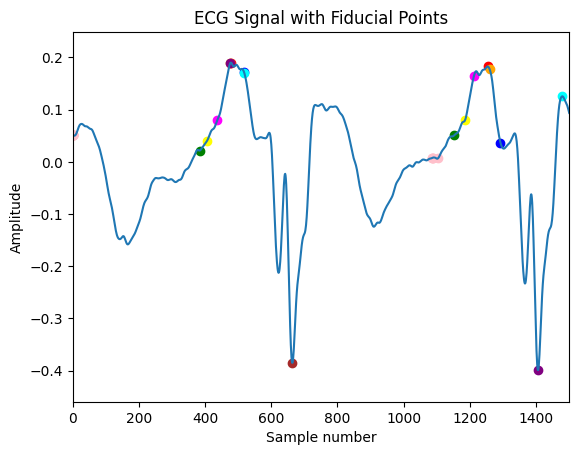

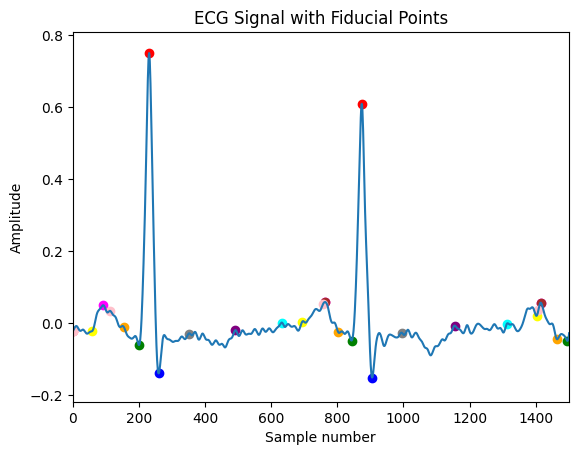

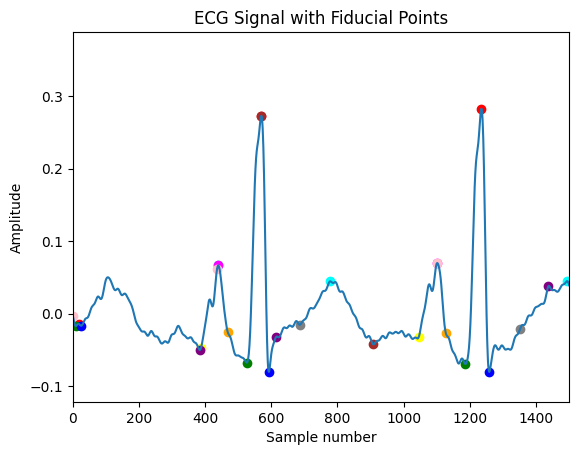

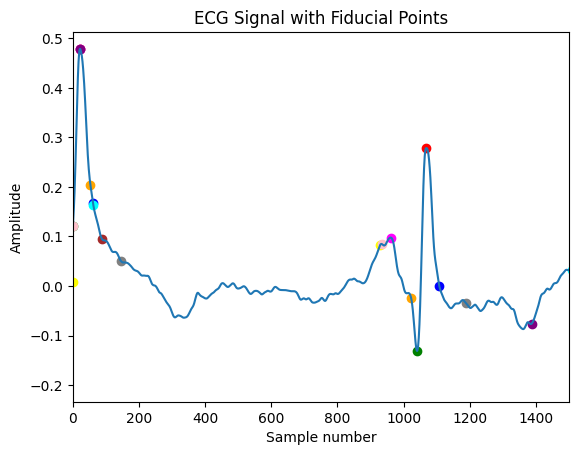

In [29]:
for i in range(4):
    plt.plot(filtered_signals[i])
    plt.scatter(R_indices[i], filtered_signals[i][R_indices[i]], c='red')
    plt.scatter(Q_indices[i], filtered_signals[i][Q_indices[i]], c='green')
    plt.scatter(S_indices[i], filtered_signals[i][S_indices[i]], c='blue')
    plt.scatter(T_indices[i], filtered_signals[i][T_indices[i]], c='cyan')
    plt.scatter(P_indices[i], filtered_signals[i][P_indices[i]], c='magenta')
    plt.scatter(P_onset[i], filtered_signals[i][P_onset[i]], c='yellow')
    plt.scatter(P_offset[i], filtered_signals[i][P_offset[i]], c='orange')
    plt.scatter(T_onset[i], filtered_signals[i][T_onset[i]], c='purple')
    plt.scatter(T_offset[i], filtered_signals[i][T_offset[i]], c='brown')
    plt.scatter(QRS_onset[i], filtered_signals[i][QRS_onset[i]], c='pink')
    plt.scatter(QRS_offset[i], filtered_signals[i][QRS_offset[i]], c='gray')

    plt.xlabel('Sample number')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1500)
    plt.title('ECG Signal with Fiducial Points')
    plt.show()

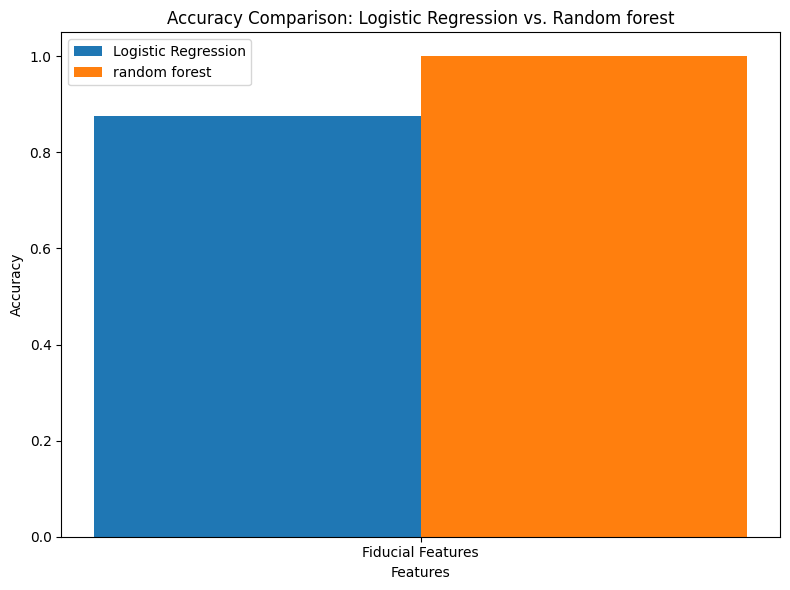

In [32]:
import matplotlib.pyplot as plt

# Define the accuracy values
accuracy_lr = [0.875]
accuracy_random = [1.0]

# Define the labels for the x-axis
labels = ['Fiducial Features']

# Set the width of the bars
bar_width = 0.35

# Create a larger figure
fig, ax = plt.subplots(figsize=(8, 6))

# Set the positions of the bars on the x-axis
r1 = range(len(accuracy_random))
r2 = [x + bar_width for x in r1]

# Plot the bars
ax.bar(r1, accuracy_lr, width=bar_width, label='Logistic Regression')
ax.bar(r2, accuracy_random, width=bar_width, label='random forest')

# Add labels, title, and legend
ax.set_xlabel('Features')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison: Logistic Regression vs. Random forest')
ax.set_xticks([r + bar_width/2 for r in range(len(accuracy_random))])
ax.set_xticklabels(labels)
ax.legend()

# Adjust the spacing between subplots to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()
